In [1]:
from vehicle_detection_utils import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import pickle
from scipy.ndimage.measurements import label
from queue import Queue
%matplotlib inline
%load_ext autoreload 
%autoreload 2
class VehicleDetectionPipeline(object):
    def __init__(self, model_file, scaler_file,
                 orient=9, pix_per_cell=8,
                 cell_per_block=2,
                 hist_bins=32,
                 cell_per_step=3,
                 threshold=13,
                 spatial_size=(32,32)):
        self.svc_model = None
        self.scaler = None
        assert(os.path.exists(model_file))
        assert(os.path.exists(scaler_file))
        with open(model_file, 'rb') as f:
            self.svc_model = pickle.load(f)
        with open(scaler_file, 'rb') as f:
            self.scaler = pickle.load(f)
        self.heat_map = None
        self.heat_map_queue = []
        self.scales = [3]
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hist_bins = hist_bins
        self.cell_per_step = cell_per_step
        self.threshold = threshold
        self.spatial_size = spatial_size
        self.queue_max_size = 10

    def get_average_heat_map_queue(self):
        if len(self.heat_map_queue) == self.queue_max_size:
            return np.average(np.array(self.heat_map_queue), axis=0)
        return None

    def add_heat_map_to_queue(self, heat_map):
        if len(self.heat_map_queue) == self.queue_max_size:
            self.heat_map_queue.pop(0)
        self.heat_map_queue.append(heat_map)

    def get_heat_map_avg(self, new_heatmap, count):
        self.heat_map = self.heat_map + (new_heatmap - self.heat_map) / (count + 1)

    def run(self, video_file, save_video=False, debug=True):
        assert os.path.exists(video_file)
        print ("Start Video Processing")
        # open the video and feed the frame here
        cap = cv2.VideoCapture(video_file)
        if save_video:
            codec = cv2.VideoWriter_fourcc(*'MJPG')
            out = cv2.VideoWriter('output.avi', codec, 20.0, (1280, 720))
        count = 0
        frame_count = 0
        while cap.isOpened():
            ret, orig_frame = cap.read()
            # if frame is valid then run it through the pipe line
            if not ret:
                break
            # run sliding windows on the interest area of each frame
            if self.heat_map is None:
                self.heat_map = np.zeros((orig_frame.shape[0], orig_frame.shape[1]))
            ystart = 380
            labels = None
            heat_map = np.zeros((orig_frame.shape[0], orig_frame.shape[1]))
            print("Good Y Range: %d %d" % (orig_frame.shape[0]//2, orig_frame.shape[0]-100))
            for i, scale in enumerate(self.scales):
                ystop = ystart + 220
                print(ystart, ystop)
                print(orig_frame.shape)
                heat_map = slide_windows_and_update_heat_map(orig_frame,
                                                      ystart,
                                                      ystop,
                                                      scale,
                                                      self.svc_model,
                                                      self.scaler,
                                                      self.orient,
                                                      self.pix_per_cell,
                                                      self.cell_per_block,
                                                      self.spatial_size,
                                                      self.hist_bins,
                                                      window_size=64,
                                                      cells_per_step=self.cell_per_step,
                                                      threshold=self.threshold,
                                                      heat_map=heat_map)
            #assert(labels is not None)
            #self.get_heat_map_avg(heat_map, count)
            self.add_heat_map_to_queue(heat_map)
            self.heat_map = self.get_average_heat_map_queue()
            #cv2.line(orig_frame, (0,400), (orig_frame.shape[1],400),(255,0,0),5)
            #cv2.line(orig_frame, (0,orig_frame.shape[0] - 100), (orig_frame.shape[1],orig_frame.shape[0]-100),(0,255,0),5)
            if self.heat_map is not None:
                self.heat_map[heat_map <= self.threshold] = 0
                labels = label(self.heat_map)
                draw_bounding_boxes_from_labels(orig_frame, labels)
            if save_video:
                out.write(orig_frame)
            # show image
            if debug:
                cv2.imshow('Frame', orig_frame)
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break

                if cv2.waitKey(0) & 0xFF == ord('s'):
                    cv2.imwrite("test_img/test%s.png"%frame_count, orig_frame)
                    frame_count += 1

                if self.heat_map is not None:
                    cv2.imshow('heatmap', self.heat_map)
                    if cv2.waitKey(25) & 0xFF == ord('q'):
                        break
            count += 1
        if save_video:
            out.release()
        cap.release()


In [2]:
with open('models/svc_model_C_0_0_1_new.pkl', 'rb') as f:
    print ("load model")
    svc_model = pickle.load(f)
with open('models/svc_scaler_rbf_C_0_0_1_new.pkl', 'rb') as f:
    print ("load scaler")
    scaler = pickle.load(f)
        

load model
load scaler


In [379]:
ystart = 350
ystop = 600
orient=9
pix_per_cell=8
cell_per_block=2
hist_bins=32
cell_per_step=1
threshold=10
spatial_size=(32,32)
scales = [2.5, 2]
#orig_frame = cv2.imread('test_img/test37.png')
#heat_map = np.zeros((orig_frame.shape[0], orig_frame.shape[1]))

hog shape (14, 79, 2, 2, 9)
Decision: 1.40
Decision: 1.79
Decision: 2.65
Decision: 2.72
Decision: 1.36
Decision: 1.17
Decision: 1.50
Total Window count 584
hog shape (11, 63, 2, 2, 9)
Decision: 1.15
Decision: 1.31
Total Window count 285
Heatmap values 5.0 0.0
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


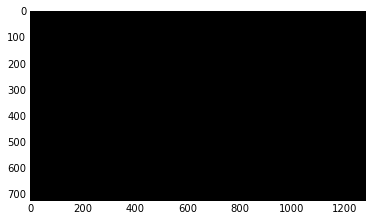

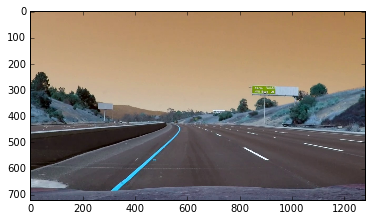

In [390]:
heat_maps = []
for i in range(0, 1):
    heat_map = np.zeros((orig_frame.shape[0], orig_frame.shape[1]))
    for scale in scales:
        orig_frame = cv2.imread('test_img/test%d.png' % i)
        #heat_map = np.zeros((orig_frame.shape[0], orig_frame.shape[1]))
        heat_map = slide_windows_and_update_heat_map(orig_frame,
                                        ystart,
                                        ystop,                                                    
                                        scale,
                                        svc_model,
                                        scaler,
                                        orient,
                                        pix_per_cell,
                                        cell_per_block,
                                        spatial_size,
                                        hist_bins,
                                        window_size=80,
                                        cells_per_step=cell_per_step,
                                        threshold=threshold,
                                        heat_map=heat_map)
    heat_maps.append(heat_map)
    #plt.figure()
    #plt.imshow(heat_map, cmap='gray')
    #print("Heatmap values",np.max(heat_map), np.min(heat_map))
    # average heatmap
heat_map = np.average(np.array(heat_maps), axis=0)
print (heat_map)
heat_map[heat_map <= threshold] = 0
labels = label(heat_map)
draw_bounding_boxes_from_labels(orig_frame, labels)
plt.figure()
plt.imshow(heat_map, cmap='gray')
plt.figure()
plt.imshow(orig_frame)


In [18]:
ystart = 350
ystop = 600
orient=9
pix_per_cell=8
cell_per_block=2
hist_bins=32
cell_per_step=1
threshold=5
spatial_size=(32,32)
scales = [2]
orig_frame = cv2.imread('test_img0/test37.png')
#heat_map = np.zeros((orig_frame.shape[0], orig_frame.shape[1]))

hog shape (14, 79, 2, 2, 9)
Total Window count 584
Heatmap values 23.0 0.0
hog shape (14, 79, 2, 2, 9)
Total Window count 584
Heatmap values 22.0 0.0
hog shape (14, 79, 2, 2, 9)
Total Window count 584
Heatmap values 17.0 0.0
hog shape (14, 79, 2, 2, 9)
Total Window count 584
Heatmap values 24.0 0.0
hog shape (14, 79, 2, 2, 9)
Total Window count 584
Heatmap values 10.0 0.0
14.4
BBox :  ((928, 382), (1183, 525))  bbox area: 36465
BBox :  ((80, 430), (239, 557))  bbox area: 20193
BBox :  ((608, 430), (687, 509))  bbox area: 6241


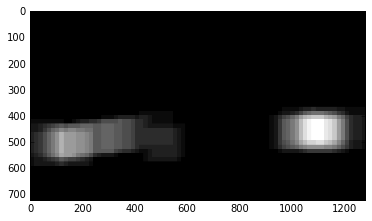

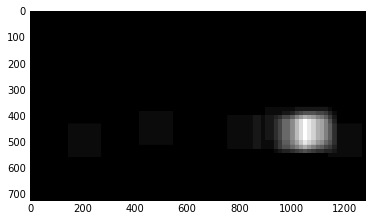

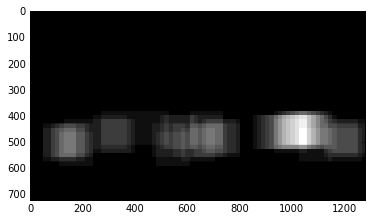

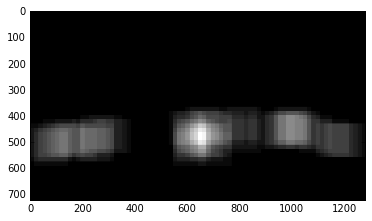

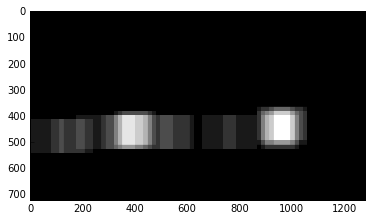

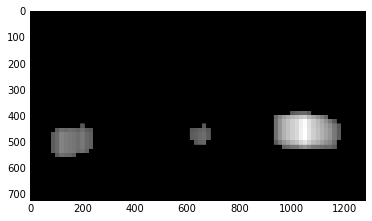

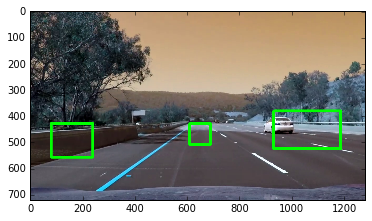

In [19]:
heat_maps = []
for i in range(103, 108):
    heat_map = np.zeros((orig_frame.shape[0], orig_frame.shape[1]))
    for scale in scales:
        orig_frame = cv2.imread('test_img0/test%d.png' % i)
        #heat_map = np.zeros((orig_frame.shape[0], orig_frame.shape[1]))
        heat_map = slide_windows_and_update_heat_map(orig_frame,
                                        ystart,
                                        ystop,                                                    
                                        scale,
                                        svc_model,
                                        scaler,
                                        orient,
                                        pix_per_cell,
                                        cell_per_block,
                                        spatial_size,
                                        hist_bins,
                                        window_size=64,
                                        cells_per_step=cell_per_step,
                                        threshold=threshold,
                                        heat_map=heat_map)
    heat_maps.append(heat_map)
    plt.figure()
    plt.imshow(heat_map, cmap='gray')
    print("Heatmap values",np.max(heat_map), np.min(heat_map))
    # average heatmap
heat_map = np.average(np.array(heat_maps), axis=0)
print (np.max(heat_map))
#heat_map[heat_map <= threshold] = 0
heat_map[heat_map < threshold] = 0
labels = label(heat_map)
draw_bounding_boxes_from_labels(orig_frame, labels)
plt.figure()
plt.imshow(heat_map, cmap='gray')
plt.figure()
plt.imshow(orig_frame)


In [248]:
np.zeros((2,3))

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])